# Hypothesis testing validation

Power analysis for DM, DV, and DC

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
import string
from sklearn.datasets import make_spd_matrix


In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [3]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/schypo')
import estimator, simulate, schypo, bootstrap, util, hypothesis_test

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [4]:
data_path = '/data/parameter_estimation/'

fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig3/'

### Read the interferon data

In [5]:
ifn_adata = sc.read(data_path + 'interferon_filtered.h5ad')


### Calibration on real data

In [6]:
q = 0.07

In [7]:
cal_adata = ifn_adata[ifn_adata.obs.cell == 'CD4 T cells'].copy()
# cal_adata.obs['stim'] = np.random.choice(['stim', 'ctrl'], cal_adata.shape[0])

In [86]:
cal_adata.shape

(10342, 35635)

In [87]:
schypo.create_groups(
    cal_adata,
    q=q,
    label_columns=['stim', 'ind'], 
    inplace=True)
schypo.compute_1d_moments(
    cal_adata, 
    inplace=True, 
    filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.05, 
    min_perc_group=.9)
print(cal_adata.shape)
schypo.ht_1d_moments(
	cal_adata, 
	formula_like='1 + stim',
	cov_column='stim',
	num_boot=1000,
    num_cpus=6,
    verbose=3)

(10342, 1719)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done 428 tasks      | elapsed:    8.7s
[Parallel(n_jobs=6)]: Done 1068 tasks      | elapsed:   22.1s
[Parallel(n_jobs=6)]: Done 1708 out of 1719 | elapsed:   35.4s remaining:    0.2s
[Parallel(n_jobs=6)]: Done 1719 out of 1719 | elapsed:   35.5s finished


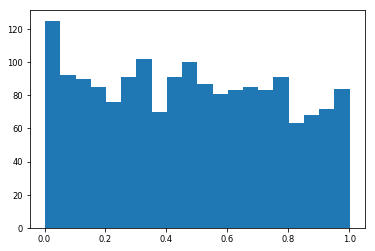

In [88]:
plt.hist(cal_adata.uns['schypo']['1d_ht']['var_asl'], bins=20);

In [ ]:
plt.hist(cal_adata.uns['schypo']['1d_ht']['mean_asl'], bins=20);

### Power calculation

1000 genes total, 300 are DE and 300 are DV

In [8]:
adata = ifn_adata[ifn_adata.obs.cell_type == 'CD4 T cells - ctrl']
# data = adata.X.copy()
# relative_data = data.toarray()/data.sum(axis=1)

n_cells = 10000
q=0.07
x_param, z_param, Nc, good_idx = simulate.extract_parameters(adata.X, q=q)

In [224]:
def simulate_two_datasets(x_param, Nc, n_cells, q, diff='mean'):
    
    log_means_1, log_variances_1 = np.log(x_param[0]), np.log(x_param[1])
    log_means_2, log_variances_2 = log_means_1.copy(), log_variances_1.copy()
    
    if diff == 'null':
        norm_cov_1, norm_cov_2 = 'indep', 'indep'
    if diff == 'mean':
        log_means_2[:500] += 0.5
        norm_cov_1, norm_cov_2 = 'indep', 'indep'
    if diff == 'variability':
        log_variances_2[:500] += 0.5
        norm_cov_1, norm_cov_2 = 'indep', 'indep'
    if diff == 'correlation':
        norm_cov_1 = make_spd_matrix(log_means_1.shape[0])
        norm_corr_1 = norm_cov_1/np.outer(np.sqrt(np.diag(norm_cov_1)), np.sqrt(np.diag(norm_cov_1)))
        norm_corr_subset = norm_corr_1[:100, :100].copy()
        
        change_indices = np.where(norm_corr_subset < 0.5)
        change_indices = (change_indices[0][:150], change_indices[1][:150])
        norm_corr_subset[change_indices] += 0.5
        
        norm_corr_2 = norm_corr_1.copy()
        norm_corr_2[:100, :100] = norm_corr_subset
        norm_cov_2 = norm_corr_2 * np.outer(np.sqrt(np.diag(norm_cov_1)), np.sqrt(np.diag(norm_cov_1)))
    
    data_1 = simulate.simulate_transcriptomes(
        n_cells=n_cells, 
        means=np.exp(log_means_1)*Nc.mean(),
        variances=(np.exp(log_variances_1) + np.exp(log_means_1)**2)*(Nc**2).mean() - np.exp(log_means_1)**2*Nc.mean()**2,
        Nc=Nc,
        norm_cov=norm_cov_1)
    
    data_2 = simulate.simulate_transcriptomes(
        n_cells=n_cells, 
        means=np.exp(log_means_2)*Nc.mean(),
        variances=(np.exp(log_variances_2) + np.exp(log_means_2)**2)*(Nc**2).mean() - np.exp(log_means_2)**2*Nc.mean()**2,
        Nc=Nc,
        norm_cov=norm_cov_2)
    
    true_data = np.vstack([data_1, data_2])
    _, hyper_captured = simulate.capture_sampling(true_data, q=q, process='hyper')
    
    anndata = sc.AnnData(sp.sparse.csr_matrix(hyper_captured))
    anndata.obs['ct_real'] = ['A' for i in range(n_cells)] + ['B' for i in range(n_cells)]
    anndata.obs['ct_shuffled'] = np.random.choice(['A', 'B'], anndata.shape[0])
    
    if diff == 'correlation':
        return anndata, change_indices
    else:
        return anndata, None

    
def calculate_power(n_cells, test='mean', test_null=False):
    
    sim_adata, change_indices = simulate_two_datasets(x_param, Nc, n_cells, q=q, diff=test if not test_null else 'null')
        
    schypo.create_groups(
        sim_adata,
        q=q,
        label_columns=['ct_real'], 
        inplace=True)
    
    schypo.compute_1d_moments(
        sim_adata, 
        inplace=True, 
        filter_genes=False, 
        residual_var=True,
        filter_mean_thresh=0.0, 
        min_perc_group=.9)
        
    if test == 'mean':

        schypo.ht_1d_moments(
            sim_adata, 
            formula_like='1 + ct_real',
            cov_column='ct_real',
            num_boot=5000,
            num_cpus=6,
            verbose=3)

        power = (sim_adata.uns['schypo']['1d_ht']['mean_asl'][:500] < 0.05).mean()
        pvals = sim_adata.uns['schypo']['1d_ht']['mean_asl']
        
    if test == 'variability':

        schypo.ht_1d_moments(
            sim_adata, 
            formula_like='1 + ct_real',
            cov_column='ct_real',
            num_boot=5000,
            num_cpus=6,
            verbose=3)
        
        power = (sim_adata.uns['schypo']['1d_ht']['var_asl'][:500] < 0.05).mean()
        pvals = sim_adata.uns['schypo']['1d_ht']['var_asl']
        
    if test == 'correlation':
        
        schypo.compute_2d_moments(
            sim_adata, 
            inplace=True, 
            gene_1=np.arange(50).astype(str).tolist(),
            gene_2=np.arange(50).astype(str).tolist())
        
        schypo.ht_2d_moments(
            sim_adata, 
            formula_like='1 + ct_real',
            cov_column='ct_real',
            num_boot=5000,
            num_cpus=6,
            verbose=3)
        
        c_pv = sim_adata.uns['schypo']['2d_ht']['corr_asl'][:50, :50]
        power = (c_pv[change_indices] < 0.05).mean()
        pvals = sim_adata.uns['schypo']['2d_ht']['corr_asl']
                
    return power, pvals, sim_adata

In [ ]:
mean_power, var_power, corr_power = [], [], []
n_cells_list = np.logspace(2, 5, 25).astype(int)
for n_cells in n_cells_list:
    
    print(n_cells)
    
    mean_power.append(calculate_power(n_cells, test='mean')[0])
    var_power.append(calculate_power(n_cells, test='variability')[0])
    corr_power.append(calculate_power(n_cells, test='correlation')[0])

with open('temp.pkl', 'wb') as f:
    pkl.dump([mean_power, var_power, corr_power], f)

In [242]:
n_cells_list = np.logspace(2, 5, 25).astype(int)

with open('/data/parameter_estimation/simulation/power_analysis.pkl', 'rb') as f:
    mean_power, var_power, corr_power = pkl.load(f)

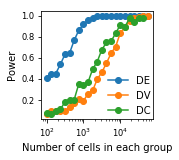

In [252]:
plt.figure(figsize=(2, 2))
plt.plot(n_cells_list[:23], mean_power, '-o')
plt.plot(n_cells_list[:23], var_power, '-o')
plt.plot(n_cells_list[:22], corr_power, '-o')
plt.xscale('log')
plt.xlabel('Number of cells in each group')
plt.ylabel('Power')
plt.legend(['DE', 'DV', 'DC'], loc='lower right', bbox_to_anchor=(0.56, -0.05, 0.5, 0.5), frameon=False)
plt.savefig(fig_path + 'power.pdf', bbox_inches='tight')

In [76]:
# with open('temp.pkl', 'wb') as f:
#     pkl.dump([mean_power, var_power, corr_power], f)

### Generate p-value histograms

In [198]:
adata = ifn_adata[ifn_adata.obs.cell_type == 'CD4 T cells - ctrl']
# data = adata.X.copy()
# relative_data = data.toarray()/data.sum(axis=1)

n_cells = 5000
q=0.07
x_param, z_param, Nc, good_idx = simulate.extract_parameters(adata.X, q=q, min_mean=0.001)

In [199]:
sim_adata_mean, _ = simulate_two_datasets(x_param, Nc, n_cells, q=q, diff='mean')

In [200]:
print(sim_adata_mean.shape)

schypo.create_groups(
    sim_adata_mean,
    q=q,
    label_columns=['ct_real'], 
    inplace=True)
schypo.compute_1d_moments(
    sim_adata_mean, 
    inplace=True, 
    filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.00001, 
    min_perc_group=.9)
schypo.ht_1d_moments(
	sim_adata_mean, 
	formula_like='1 + ct_real',
	cov_column='ct_real',
	num_boot=5000,
    num_cpus=6,
    verbose=3)

(10000, 10805)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    4.7s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:   17.5s
[Parallel(n_jobs=6)]: Done 1030 tasks      | elapsed:   26.0s
[Parallel(n_jobs=6)]: Done 1734 tasks      | elapsed:   37.1s
[Parallel(n_jobs=6)]: Done 2566 tasks      | elapsed:   50.3s
[Parallel(n_jobs=6)]: Done 3526 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 4614 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 5830 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 7174 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 8646 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 10246 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done 10798 out of 10798 | elapsed:  3.0min finished


In [201]:
sim_adata_mean.write('/data/parameter_estimation/simulation/sim_mean.h5ad')

... storing 'ct_real' as categorical
... storing 'ct_shuffled' as categorical
... storing 'schypo_group' as categorical


In [147]:
sim_adata_var, _ = simulate_two_datasets(x_param, Nc, n_cells, q=q, diff='variability')

schypo.create_groups(
    sim_adata_var,
    q=q,
    label_columns=['ct_real'], 
    inplace=True)
schypo.compute_1d_moments(
    sim_adata_var, 
    inplace=True, 
    filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.05, 
    min_perc_group=.9)
schypo.ht_1d_moments(
	sim_adata_var, 
	formula_like='1 + ct_real',
	cov_column='ct_real',
	num_boot=5000,
    num_cpus=6,
    verbose=3)

(10000, 10800)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 220 tasks      | elapsed:    6.9s
[Parallel(n_jobs=6)]: Done 540 tasks      | elapsed:   15.8s
[Parallel(n_jobs=6)]: Done 988 tasks      | elapsed:   28.4s
[Parallel(n_jobs=6)]: Done 1564 tasks      | elapsed:   45.8s
[Parallel(n_jobs=6)]: Done 2268 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2364 out of 2375 | elapsed:  1.1min remaining:    0.3s
[Parallel(n_jobs=6)]: Done 2375 out of 2375 | elapsed:  1.2min finished


In [158]:
sim_adata_var.write('/data/parameter_estimation/simulation/sim_var.h5ad')

... storing 'ct_real' as categorical
... storing 'ct_shuffled' as categorical
... storing 'schypo_group' as categorical


In [225]:
x_param, z_param, Nc, good_idx = simulate.extract_parameters(adata.X, q=q, min_mean=0.05)
sim_adata_corr, change_indices = simulate_two_datasets(x_param, Nc, n_cells, q=q, diff='correlation')


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scipy/stats/_multivariate.py:660: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [226]:
schypo.create_groups(
    sim_adata_corr,
    q=q,
    label_columns=['ct_real'], 
    inplace=True)
schypo.compute_1d_moments(
    sim_adata_corr, 
    inplace=True, 
    filter_genes=True, 
    residual_var=True,
    filter_mean_thresh=0.0, 
    min_perc_group=.9)
schypo.compute_2d_moments(
    sim_adata_corr, 
    inplace=True, 
    gene_1=np.arange(100).astype(str).tolist(),
    gene_2=np.arange(100).astype(str).tolist())
schypo.ht_2d_moments(
    sim_adata_corr, 
    formula_like='1 + ct_real',
    cov_column='ct_real',
    num_boot=5000,
    num_cpus=6,
    verbose=3)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    2.5s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    7.6s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:   16.4s
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:   27.1s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   42.1s
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 2580 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 3860 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 4596 tasks      | elapsed:  4.5min
[Parallel(n_jobs=6)]: Done 4950 out of 4950 | elapsed:  4.8min finished


In [227]:
sim_adata_corr.uns['null'] = corr_asl_null

In [228]:
sim_adata_corr.write('/data/parameter_estimation/simulation/sim_corr.h5ad')

... storing 'ct_real' as categorical
... storing 'ct_shuffled' as categorical
... storing 'schypo_group' as categorical


### Plot p-value histograms

In [194]:
sim_adata_var = sc.read('/data/parameter_estimation/simulation/sim_var.h5ad')
var_asl = sim_adata_var.uns['schypo']['1d_ht']['var_asl']

In [202]:
sim_adata_mean = sc.read('/data/parameter_estimation/simulation/sim_mean.h5ad')
mean_asl = sim_adata_mean.uns['schypo']['1d_ht']['mean_asl']

In [231]:
sim_adata_corr = sc.read('/data/parameter_estimation/simulation/sim_corr.h5ad')
corr_asl = sim_adata_corr.uns['schypo']['2d_ht']['corr_asl'].ravel()
corr_null_asl = sim_adata_corr.uns['null'].ravel()

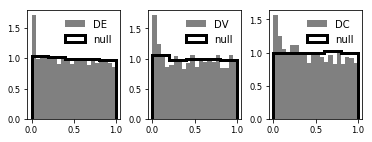

In [253]:
plt.figure(figsize=(6, 2));
plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 3, 1);
plt.hist(mean_asl, bins=20, density=True, color='grey', label='DE');
plt.hist(mean_asl[500:], bins=5, density=True, histtype='step', linewidth=3, color='black', label='null');
plt.legend(frameon=False)

plt.subplot(1, 3, 2);
plt.hist(var_asl, bins=20, density=True, color='grey', label='DV');
plt.hist(var_asl[500:], bins=5, density=True, histtype='step', linewidth=3, color='black', label='null');
plt.legend(frameon=False)

plt.subplot(1, 3, 3);
plt.hist(corr_asl.ravel(), density=True, color='grey', bins=20, label='DC');
plt.hist(corr_asl_null.ravel(), bins=5, density=True, color='black', label='null', histtype='step', linewidth=3);
plt.legend(frameon=False)
plt.savefig(fig_path + 'calibration_histograms.pdf', bbox_inches='tight')